In [48]:
from pong_game import PongEnv  # 파일명에서 .py를 제외하고 임포트
env = PongEnv(render_mode=None)
print("환경 로드 성공!")

환경 로드 성공!


In [49]:
import os, random, collections
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from IPython import display
import matplotlib.pyplot as plt

print("라이브러리 로드 완료!")

라이브러리 로드 완료!


In [50]:
# 신경망 구조 정의
class QNet(nn.Module):
    def __init__(self):
        super(QNet, self).__init__()
        # TODO 1-1
        self.fc1 = nn.Linear(5, 64)
        self.fc2 = nn.Linear(64, 3)

    def forward(self, x):
        # TODO 1-2
        x = F.relu(self.fc1(x))
        return self.fc2(x)

    def sample_action(self, obs, epsilon):
        # 모험(Exploration) vs 선택(Exploitation)
        # TODO 2
        out = self.forward(obs)
        if random.random() < epsilon:
            return random.randint(0, 2)
        else:
            return out.argmax().item()

print("신경망 구조 정의 완료!")

신경망 구조 정의 완료!


In [51]:
def train(q, q_target, memory, optimizer):
    # 메모리에서 랜덤하게 경험 추출
    s, a, r, s_prime, done_mask = zip(*random.sample(memory, batch_size))

    # 데이터를 텐서로 변환 (속도 최적화)
    s = torch.tensor(np.array(s), dtype=torch.float)
    a = torch.tensor(a).unsqueeze(1)
    r = torch.tensor(r, dtype=torch.float).unsqueeze(1)
    s_prime = torch.tensor(np.array(s_prime), dtype=torch.float)
    done_mask = torch.tensor(done_mask, dtype=torch.float).unsqueeze(1)

    # Q-러닝 오차 계산
    q_out = q(s)
    q_a = q_out.gather(1, a)
    max_q_prime = q_target(s_prime).max(1)[0].unsqueeze(1)

    # TODO 3-1
    target = r + gamma * max_q_prime * done_mask

    loss = F.mse_loss(q_a, target)

    # 신경망 업데이트
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [52]:
q = QNet()
q_target = QNet()
q_target.load_state_dict(q.state_dict())
optimizer = optim.Adam(q.parameters(), lr=learning_rate)
memory = collections.deque(maxlen=buffer_limit)
score_history = []  # 점수 기록용

print("AI 탄생! 이제 학습을 시작할 준비가 되었습니다.")

AI 탄생! 이제 학습을 시작할 준비가 되었습니다.


In [53]:
# 하이퍼파라미터
learning_rate = 0.001
gamma         = 0.99
batch_size    = 64
buffer_limit  = 10000

# 모델 초기화
q = QNet()
q_target = QNet()
q_target.load_state_dict(q.state_dict())

# 최적화 도구 재설정
optimizer = optim.Adam(q.parameters(), lr=learning_rate)

# 기억 장치 초기화
memory = collections.deque(maxlen=100000)

# 그래프용 기록 초기화
score_history = []
max_avg_score = 0

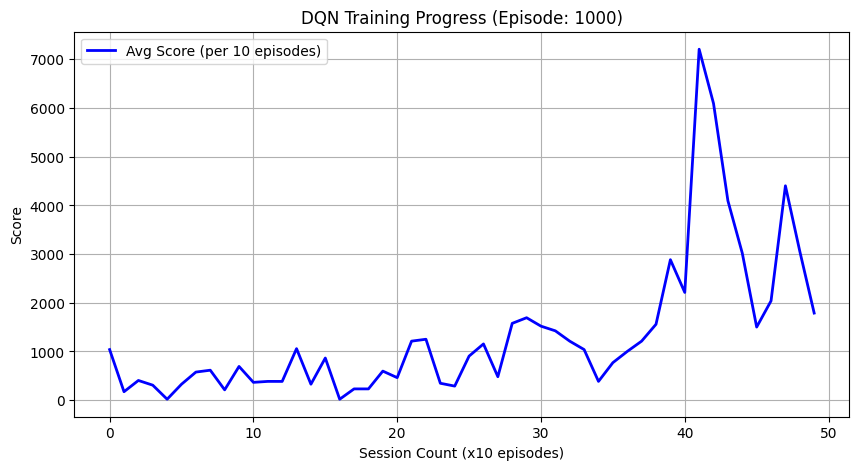

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
[학습 현황] 에피소드: 1000 / 1000
현재 평균 점수:  1788.8 점
역대 최고 점수:  7208.2 점
모험 확률(ε):  81.38% (학습할수록 낮아집니다)
기억 저장소:  100000 / 100000 개
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

학습 완료!
최종 최고 기록: 7208.2점


In [54]:
def plot_res(scores, n_epi, num_episodes, max_avg_score, epsilon, memory_len):
    display.clear_output(wait=True)
    plt.figure(figsize=(10, 5))
    plt.plot(scores, label='Avg Score (per 10 episodes)', color='b', linewidth=2)
    plt.title(f'DQN Training Progress (Episode: {n_epi})')
    plt.xlabel('Session Count (x10 episodes)')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
    print(f"[학습 현황] 에피소드: {n_epi} / {num_episodes}")
    print(f"현재 평균 점수: {scores[-1]:7.1f} 점")
    print(f"역대 최고 점수: {max_avg_score:7.1f} 점")
    print(f"모험 확률(ε): {epsilon:7.2%} (학습할수록 낮아집니다)")
    print(f"기억 저장소: {memory_len:7d} / 100000 개")
    print(f"━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")

num_episodes = 1000
env = PongEnv(render_mode=None)
current_total_score = 0
max_avg_score = 0

print("학습 준비 중...")

for n_epi in range(1, num_episodes + 1):
    s = env.reset()
    done = False

    while not done:
        # 학습이 진행될수록(score_history가 쌓일수록) 모험심(epsilon) 줄이기
        total_steps = len(score_history) * 10 + n_epi

        # TODO 4
        epsilon = max(0.05, 1.0 - total_steps / 8000)

        a = q.sample_action(torch.from_numpy(s).float(), epsilon)
        s_prime, r, done, info = env.step(a)

        # 경험 저장
        memory.append((s, a, r, s_prime, 0.0 if done else 1.0))
        s = s_prime
        current_total_score += info['score']

        # 경험이 쌓이면 학습 시작
        if len(memory) > 500:
            train(q, q_target, memory, optimizer)

    # 10번의 에피소드마다 그래프와 수치를 갱신
    if n_epi % 20 == 0:
        avg_score = current_total_score / 10
        score_history.append(avg_score)

        # 최고 점수 갱신 체크
        if avg_score > max_avg_score:
            max_avg_score = avg_score

        q_target.load_state_dict(q.state_dict()) # 타겟 네트워크 동기화

        plot_res(score_history, n_epi, num_episodes, max_avg_score, epsilon, len(memory))

        current_total_score = 0

# 최종 저장
print("\n학습 완료!")
print(f"최종 최고 기록: {max_avg_score}점")

In [55]:
torch.save(q.state_dict(), "pong_model.pth")
print("모델이 'pong_model.pth'로 성공적으로 저장되었습니다. 왼쪽 파일 탭에서 다운로드하세요!")

모델이 'pong_model.pth'로 성공적으로 저장되었습니다. 왼쪽 파일 탭에서 다운로드하세요!
